Modeling Supreme Court Behaviour using Embeddings and LSTMs'
In the previous notebook, we were trying to use sequence modeling to predict the votes of justices of the Supreme Court of the United States of America. We were able to achieve an accuracy of 82.07% which was still better than the current state=of-the-art, 71.9%.

In this notebook, we will try something much simpler and much more efficient. We will create embeddings for all the categorical variables. The model will then take such high dimensional embedding vectors as inputs. The reason behind this methodology is that the model can learn some complex relationship between the features in a higher dimensional space.

In [3]:
%matplotlib inline
from __future__ import division,print_function
import gc,re
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras; import keras.backend

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, LSTM, GRU, Embedding, Convolution1D, MaxPooling1D, MaxPool1D,TimeDistributed
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb
from keras.models import load_model
import sklearn
from sklearn.metrics import confusion_matrix

import pandas
import os, json
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from keras.layers.merge import Add,Dot,Concatenate

In [4]:
# Get raw data
raw_data = pandas.read_hdf("raw_data_legacy.hdf.gz", "root")
feature_df = pandas.read_hdf("feature_data_legacy.hdf.gz", "root")


In [5]:
np.random.seed(7)

In [6]:
#There are 64 features including output variables
len(raw_data.columns)

64

## Prepare Data

Now, from this raw_data, we need to remove all the output variables, i.e. any such variable which gets populated after the decision has been made by the Supreme Court. This is because, at test time, we wont be having access to such variables.

Our target vector in this case is 'justice_outcome_disposition' which can take three values : affirm/reverse/no_opinion.

In [7]:
#Use unique to get possible values for each feature
raw_data['case_outcome_disposition'].unique()

array([ -1.,   1.,   0.,  nan])

In [8]:
feature_df_names = feature_df.columns
len(feature_df_names)

1725

Remove all the outcome variables mentioned on SCDB website, to prevent model from learning any internal dependencies in these. Out final predictions are for "case_outcome_disposition".

In [9]:
outcome = ['decisionType','declarationUncon','caseDisposition','case_outcome_disposition',\
           'partyWinning','caseDispositionUnusual','precedentAlteration','justice_outcome_disposition',\
           'splitVote','majVotes','vote','minVotes',\
          'firstAgreement','secondAgreement','opinion','direction', 'voteUnclear']

Create Target and drop all the outcome variables from the dataframe. After this operation, we see that we are only left with 47 features. This is as opposed to 1481 features in the previous notebook : we have reduced the feauture space almost 31 times.

In [10]:
whole_data = raw_data.copy()
target = whole_data['justice_outcome_disposition']
whole_data.drop(outcome,axis=1, inplace=True)

whole_data.shape

(249793, 47)

Let us see the feautures we will be training our model on.

In [11]:
feature_names = whole_data.columns
feature_names

Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term', 'naturalCourt',
       'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg',
       'petitioner', 'petitionerState', 'respondent', 'respondentState',
       'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc',
       'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState',
       'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'issue', 'issueArea', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'justice', 'justiceName', 'majority', 'lc_case_outcome_disposition'],
      dtype='object')

Some preprocessing on the data before creating embedding :

1. Fill all nan with -10
2. Create a dictionary by giving a number to each possibly unique value of the feature. The reason we are doing this is, the unique values for a feature can take any sort of value. For eg, unique values in caseIDs are like 1791-001, 1791-003 etc. What we want to do instead is assign consecutive numeric integers to each unique value in a feature. Since the features are categorical, we are not concerned with their specific value, we just need each specific value to be different.

In [12]:
list_dict = []
for feature in feature_names:
    whole_data[feature] = whole_data[feature].fillna(-10)
    n_features = whole_data[feature].unique()
    feature2idx = {o : i for i,o in enumerate(n_features)}
    list_dict.append(feature2idx)
len(list_dict)

47

Now that we have the mapping of each unique value of a feature to some consecutive integers, we can replace all values in main dataframe with new numerical values.

In [13]:
for i,feature in enumerate(feature_names):
    whole_data[feature] = whole_data[feature].apply(lambda x : list_dict[i][x])

In [14]:
whole_data['lawType'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

For Stateful LSTM, we need size of data to be divisible by batch size. 
Since batch size was chosen as 512 and 0.8(4/5) (train and validation split) should divide train data size.
This intuition combined with trail and error to keep the split close to 85%, following values were chosen.


In [15]:
data = whole_data.as_matrix()
rows = round(0.87112*len(data))
X_train = data[0:rows]
X_test = data[rows:len(data)]
y_train = target[0:rows]
y_test = target[rows:len(data)]

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(217600, 47) (32193, 47) (217600, 3) (32193, 3)


In [17]:
list_of_inputs = []
for i,feature in enumerate(feature_names):
    list_of_inputs.append(X_train[:,i])
len(list_of_inputs)


47

In [18]:
list_of_inputs_test = []
for i,feature in enumerate(feature_names):
    list_of_inputs_test.append(X_test[:31744,i])
len(list_of_inputs_test)
y_test = target[rows:rows+31744]
y_test_cat = keras.utils.to_categorical(y_test, num_classes=3)
print(y_test.shape)


(31744,)


In [19]:
 def create_embedding_and_input_layers(embedding_size_list,batch_size,is_stateful):
        '''
        Create an Input and Embedding Layer for each of the categorical features.
        Concatenate all the embeddings.
        Keras Graph was created with the input layer composed of inputs list.
        So we return a combined list of inputs for each embedding size value.
        ip: embedding_size_list: list with embedding sizes to try
        op: Layers with input and concatenated embeddings.
        '''
        final_embedding_layer_list=[]
        inputs_all=[]
        for EMB_LEN in embedding_size_list:
            inputs=[]
            embeddings = []
            for feature in feature_names:
                if(is_stateful):
                    inp = Input(shape=(1,), name=feature, batch_shape=(batch_size,1))
                else:
                    inp = Input(shape=(1,), name=feature)                    
                n_features = whole_data[feature].nunique()
                emb_name = 'emb_'+feature
                emb = Embedding(n_features, EMB_LEN, input_length=1, name=emb_name)(inp)
                inputs.append(inp)
                embeddings.append(emb)
            inputs_all.append(inputs)
            final_embedding_layer_list.append(Concatenate()(embeddings))
        return final_embedding_layer_list,inputs_all


In [20]:
def create_LSTM_layer(lstm_cell_size,embedding_size_list,batch_size,is_stateful):
    """
    Create LSTM layer
    ip: 
    lstm_cell_size: number of LSTM cells
    op: list of LSTM layers
    Logic: size of output = no. of embedding sizes to try i.e for a given LSTM cell number, create all possible valued embedding\
    layers.    
    """
    lstm_layer_list=[]
    embedding_layers_list,inputs = create_embedding_and_input_layers(embedding_size_list,batch_size,is_stateful)
    for i,final_embs in enumerate(embedding_layers_list):
        lstm_layer_list.append(LSTM(lstm_cell_size,dropout=0.6, recurrent_dropout=0.6)(final_embs))
    return lstm_layer_list,inputs


In [21]:
def add_softmax(lstm_cell_size_list,embedding_size_list,batch_size,is_stateful,lstm_embedding_name_combinations):
    """
    Add Dense layer with softmax activation on top the LSTM and Embedding layers
    ip: 
    lstm_cell_size: number of unique LSTM cells values to try
    embedding_size_list: list with embedding sizes to try
    lstm_embedding_name_combinations: no. of lstm cells to try * no. of embedding to try
    op: List of Models with all layers created
    """
    models=[]
    models_names=[]
    no_of_em_to_try = len(embedding_size_list)
    # Create one LSTM layer for each value
    for i,lstm_cell_size in enumerate(lstm_cell_size_list):
        lstm_layer_list,inputs = create_LSTM_layer(lstm_cell_size,embedding_size_list,batch_size,is_stateful)
        '''
        the input used for model creation, should come from same graph as input layer, so we index accordingly.
        You need to keep this in mind, else it throws lot of keras compilation erros.
        '''
        
        for j,lstm_layer in enumerate(lstm_layer_list): 
            preds = Dense(3, activation = 'softmax')(lstm_layer)
            print("*"*50)
            print("Created {}_LSTM model with lstm cells {} embedding size {} ".format((is_stateful*"stateful"),\
                                                                      lstm_embedding_name_combinations[i*no_of_em_to_try+j][0],\
                                                                      lstm_embedding_name_combinations[i*no_of_em_to_try+j][1]))
            print("*"*50)
            models.append(Model(inputs=inputs[j], outputs=preds))
    return models

In [22]:
def build_models(is_stateful,embedding_size_list,epoch_list,lstm_cell_size_list):
    batch_size=512
    models = []
    models_after_fit=[]
    models_names=[]
    
    lstm_embedding_name_combinations = [(lstm_size,em_size) for lstm_size in lstm_cell_size_list\
                                        for em_size in embedding_size_list]
    print(lstm_embedding_name_combinations)
    models=add_softmax(lstm_cell_size_list,embedding_size_list,batch_size,is_stateful,lstm_embedding_name_combinations)
        
    for i,model in enumerate(models):
        for e in epoch_list:
            model.compile(optimizer='RMSProp', loss='categorical_crossentropy' ,metrics=['accuracy'])
            K.set_value(model.optimizer.lr , 0.001)
            initial_weights = model.get_weights()
            model.fit(list_of_inputs,
                      y_train,
                      batch_size=512,
                      epochs=e,
                      validation_split=0.2,
                      shuffle=False)
            curr_eval = model.evaluate(list_of_inputs_test, y_test_cat, batch_size=512)
            print("*"*50)
            print("Test accuracy after no. of epochs : " + str(e) + " accuracy is : " + str(curr_eval[1]))
            print("*"*50)
            models_after_fit.append(model)
            name = (is_stateful*"stateful")+"model_with_lstm_cells_"+str(lstm_embedding_name_combinations[i][0])+"_emb_size_"\
                   +str(lstm_embedding_name_combinations[i][1])+"_trained_for_"+str(e)+"_epochs"
            models_names.append(name)
            model.save(name)
            model.set_weights(initial_weights)
    return models_after_fit,models_names

## Results shown for combinations of embedding sizes and no. of LSTM cells as below.

In [24]:
embedding_size_list = [75,85,100]
epoch_list = [2]
lstm_cell_size_list = [100,200]
models_with_statefulLSTM,stateful_models_names=build_models(True,embedding_size_list,epoch_list,lstm_cell_size_list)
print(stateful_models_names)

[(100, 75), (100, 85), (100, 100), (200, 75), (200, 85), (200, 100)]
**************************************************
Created stateful_LSTM model with lstm cells 100 embedding size 75 
**************************************************
**************************************************
Created stateful_LSTM model with lstm cells 100 embedding size 85 
**************************************************
**************************************************
Created stateful_LSTM model with lstm cells 100 embedding size 100 
**************************************************
**************************************************
Created stateful_LSTM model with lstm cells 200 embedding size 75 
**************************************************
**************************************************
Created stateful_LSTM model with lstm cells 200 embedding size 85 
**************************************************
**************************************************
Created stateful_LSTM model with l

In [21]:
embedding_size_list = [75,85,100]
epoch_list = [2]
lstm_cell_size_list = [100,200]
models_without_statefulLSTM,models_names=build_models(False,embedding_size_list,epoch_list,lstm_cell_size_list)
print(models_names)

[(100, 75), (100, 85), (100, 100), (200, 75), (200, 85), (200, 100)]
**************************************************
Created _LSTM model with lstm cells 100 embedding size 75 
**************************************************
**************************************************
Created _LSTM model with lstm cells 100 embedding size 85 
**************************************************
**************************************************
Created _LSTM model with lstm cells 100 embedding size 100 
**************************************************
**************************************************
Created _LSTM model with lstm cells 200 embedding size 75 
**************************************************
**************************************************
Created _LSTM model with lstm cells 200 embedding size 85 
**************************************************
**************************************************
Created _LSTM model with lstm cells 200 embedding size 100 
**************

NameError: name 'stateful_models_names2' is not defined

In [23]:
#restoring names to prevent training.
stateful_models_names = ['statefulmodel_with_lstm_cells_100_emb_size_75_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_100_emb_size_85_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_100_emb_size_100_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_200_emb_size_75_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_200_emb_size_85_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_200_emb_size_100_trained_for_2_epochs']
models_names = ['model_with_lstm_cells_100_emb_size_75_trained_for_2_epochs', 'model_with_lstm_cells_100_emb_size_85_trained_for_2_epochs', 'model_with_lstm_cells_100_emb_size_100_trained_for_2_epochs', 'model_with_lstm_cells_200_emb_size_75_trained_for_2_epochs', 'model_with_lstm_cells_200_emb_size_85_trained_for_2_epochs', 'model_with_lstm_cells_200_emb_size_100_trained_for_2_epochs']

In [24]:
print(stateful_models_names,models_names)

['statefulmodel_with_lstm_cells_100_emb_size_75_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_100_emb_size_85_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_100_emb_size_100_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_200_emb_size_75_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_200_emb_size_85_trained_for_2_epochs', 'statefulmodel_with_lstm_cells_200_emb_size_100_trained_for_2_epochs'] ['model_with_lstm_cells_100_emb_size_75_trained_for_2_epochs', 'model_with_lstm_cells_100_emb_size_85_trained_for_2_epochs', 'model_with_lstm_cells_100_emb_size_100_trained_for_2_epochs', 'model_with_lstm_cells_200_emb_size_75_trained_for_2_epochs', 'model_with_lstm_cells_200_emb_size_85_trained_for_2_epochs', 'model_with_lstm_cells_200_emb_size_100_trained_for_2_epochs']


The following summary statements are hardcoded, we will upload a generic notebook with all combinations in sometime.

## Explanation of Model Summary for Stateful Model

Comments:
In a stateful model all layers will have batch_size as first dimension size, i.e 512

Input layer : caseId (InputLayer)             (512, 1)             0 
Size is (512,1) 1 is because the input value for caseID is a scalar value

emb_caseId (Embedding)          (512, 1, 85)         2426155        
Size is (512,1,85) 85 is because the embedding size tried was 85
The input scalar value is mapped to a 85 dimension space.

concatenate_2 (Concatenate)     (512, 1, 3995)       0 
3995 is 47*85 - this has concatenated all the embedding values for all input features

## lstm_2 (LSTM)                   (512, 100)           1638400     

No. of LSTM cells used = 100.
No. of param = 1638400 - This is where the understanding of LSTM lies.
1. Each LSTM cell has 4 separate weight matrices for input, forget, output, update(g) - 4\*100
2. Each of these weight matrices has a bias unit, 4\*100
|| = size of
Total no. of param is hence ((|prev layer input| + |LSTM Cells|)\*(4\*|LSTM Cells|))+(4\*|LSTM Cells|)
i.e 
((prev layer input size+no. of lstm cells)\*(no. of weight cells for all LSTM Cells))+(No. of bias units for all weight matrices for all lstm cells)

Math with given numbers: 
term1 = (3995+100) = 4095
term2 = no. of weights = 4\*100 = 400
term3 = no. of biases = 4\*100 = 400
total = (term1\*term2)+term3 
term1\*term2= 4095\*400 = 1638000
## total = 1638400, as shown in 



dense_2 (Dense)                 (512, 3)             303        
We have 3 categories as explained before, hence dimension 3.


In [26]:
models_with_statefulLSTM[1].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caseId (InputLayer)             (512, 1)             0                                            
__________________________________________________________________________________________________
docketId (InputLayer)           (512, 1)             0                                            
__________________________________________________________________________________________________
caseIssuesId (InputLayer)       (512, 1)             0                                            
__________________________________________________________________________________________________
voteId (InputLayer)             (512, 1)             0                                            
__________________________________________________________________________________________________
dateDecisi

## Explanation of Model Summary for Normal LSTM Model

Comments:
Explanation is same as stateful model, except 
1. batch_size doesn't define dimension.
2. Amount of data doesn't have to be divisible by batch_size either.


In [27]:
models_without_statefulLSTM[1].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caseId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
docketId (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
caseIssuesId (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
voteId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
dateDecisi

In [26]:
stateful_accuracies = []
normal_accuracies=[]
stateful_prediction = []
normal_prediction = []
for i,sm in enumerate(stateful_models_names):
    print("Test Accuracy Calculation after loading model ", stateful_models_names[i])
    model_stateful = load_model(stateful_models_names[i])
    stateful_accuracies.append(model_stateful.evaluate(list_of_inputs_test, y_test_cat, batch_size=512)[1])
    stateful_prediction.append(model_stateful.predict(list_of_inputs_test, batch_size=512))
for i,m in enumerate(models_names):
    print("Test Accuracy Calculation after loading model ", models_names[i])
    model = load_model(models_names[i])
    normal_accuracies.append(model.evaluate(list_of_inputs_test, y_test_cat, batch_size=512)[1])
    normal_prediction.append(model.predict(list_of_inputs_test, batch_size=512))
print("stateful accuracies ",stateful_accuracies)
print("normal_accuracies",normal_accuracies)

Test Accuracy Calculation after loading model  statefulmodel_with_lstm_cells_100_emb_size_75_trained_for_2_epochs
31744/31744 [==============================] - 3s 109us/step
Test Accuracy Calculation after loading model  statefulmodel_with_lstm_cells_100_emb_size_85_trained_for_2_epochs
31744/31744 [==============================] - 4s 125us/step
Test Accuracy Calculation after loading model  statefulmodel_with_lstm_cells_100_emb_size_100_trained_for_2_epochs
31744/31744 [==============================] - 5s 143us/step
Test Accuracy Calculation after loading model  statefulmodel_with_lstm_cells_200_emb_size_75_trained_for_2_epochs
31744/31744 [==============================] - 5s 151us/step
Test Accuracy Calculation after loading model  statefulmodel_with_lstm_cells_200_emb_size_85_trained_for_2_epochs
31744/31744 [==============================] - 5s 167us/step
Test Accuracy Calculation after loading model  statefulmodel_with_lstm_cells_200_emb_size_100_trained_for_2_epochs
31744/317

In [27]:
y_test=y_test_cat

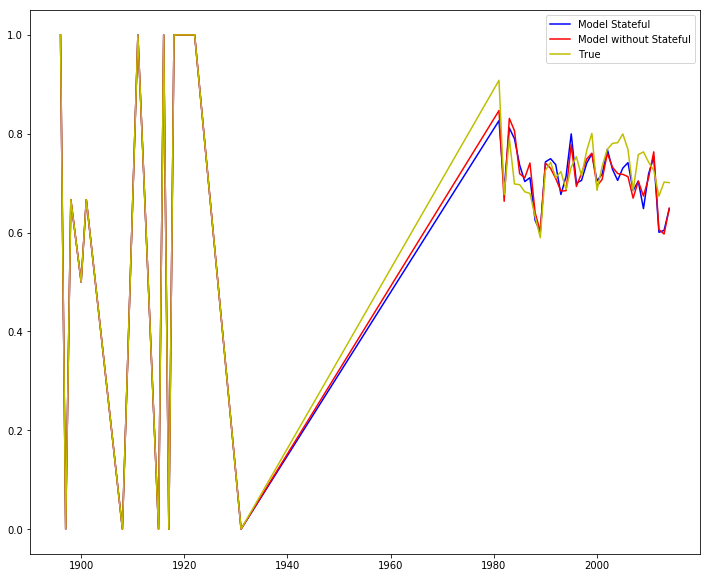

In [30]:
best_model_stateful = load_model(stateful_models_names[np.argmax(stateful_accuracies)])
best_model_without_stateful = load_model(models_names[np.argmax(normal_accuracies)])

preds_model_stateful = best_model_stateful.predict(list_of_inputs_test,batch_size=512)
preds_model_stateful = np.argmax(preds_model_stateful, axis = 1)

preds_model_without_stateful = best_model_without_stateful.predict(list_of_inputs_test,batch_size=512)
preds_model_without_stateful = np.argmax(preds_model_without_stateful, axis = 1)

preds_model_stateful_df = pandas.DataFrame(preds_model_stateful, columns=['model_stateful_predictions'])
preds_model_without_stateful_df = pandas.DataFrame(preds_model_without_stateful, columns=['model_without_stateful_predictions'])
years = feature_df[['term_raw']]
years.head(2)
years_test = years[-len(y_test) :]
years_test = years_test.reset_index()
years_test.head(2)

raw_data.loc[raw_data['justice_outcome_disposition'] == -1] = 2
justice_test = raw_data[len(y_train) :len(y_train)+len(y_test)]
justice_test = justice_test.reset_index()

temp_df = pandas.concat([preds_model_stateful_df, preds_model_without_stateful_df], axis =1)
temp_df = pandas.concat([temp_df, justice_test[['justice_outcome_disposition']]], axis = 1)
temp_df = pandas.concat([temp_df, years_test[['term_raw']]], axis=1)

per_year_avg_preds_model_stateful = temp_df.groupby("term_raw")["model_stateful_predictions"].mean()
per_year_avg_preds_model_without_stateful = temp_df.groupby("term_raw")["model_without_stateful_predictions"].mean()
per_year_avg_true_model = temp_df.groupby("term_raw")["justice_outcome_disposition"].mean()

f = plt.figure(figsize=(12, 10))
plt.plot(per_year_avg_preds_model_stateful, color = 'b')
plt.plot(per_year_avg_preds_model_without_stateful, color = 'r')
plt.plot(per_year_avg_true_model, color = 'y')
plt.legend(('Model Stateful', 'Model without Stateful', 'True'))

In [31]:
best_model_stateful = load_model(stateful_models_names[np.argmax(stateful_accuracies)])
best_model_without_stateful = load_model(models_names[np.argmax(normal_accuracies)])

preds_model_stateful = best_model_stateful.predict(list_of_inputs_test,batch_size=512)
preds_model_stateful = np.argmax(preds_model_stateful, axis = 1)

preds_model_without_stateful = best_model_without_stateful.predict(list_of_inputs_test,batch_size=512)
preds_model_without_stateful = np.argmax(preds_model_without_stateful, axis = 1)

In [32]:
print(sklearn.metrics.classification_report(preds_model_stateful, np.argmax(y_test, axis =1 )))
print(sklearn.metrics.confusion_matrix(preds_model_stateful, np.argmax(y_test, axis =1 )))
print(sklearn.metrics.accuracy_score(preds_model_stateful, np.argmax(y_test, axis =1 )))

             precision    recall  f1-score   support

          0       0.89      0.87      0.88     11562
          1       0.91      0.94      0.93     17707
          2       0.84      0.79      0.81      2475

avg / total       0.90      0.90      0.90     31744

[[10021  1424   117]
 [  844 16613   250]
 [  387   134  1954]]
0.900579637097


In [33]:
print(sklearn.metrics.classification_report(preds_model_without_stateful, np.argmax(y_test, axis =1 )))
print(sklearn.metrics.confusion_matrix(preds_model_without_stateful, np.argmax(y_test, axis =1 )))
print(sklearn.metrics.accuracy_score(preds_model_without_stateful, np.argmax(y_test, axis =1 )))

             precision    recall  f1-score   support

          0       0.89      0.87      0.88     11572
          1       0.91      0.94      0.93     17718
          2       0.83      0.78      0.81      2454

avg / total       0.90      0.90      0.90     31744

[[10022  1415   135]
 [  843 16613   262]
 [  387   143  1924]]
0.899666078629
